# Upload video for frame extration


Saving (67) Pendular Nystagmus - YouTube - Google Chrome 2023-11-23 08-34-34.mp4 to (67) Pendular Nystagmus - YouTube - Google Chrome 2023-11-23 08-34-34.mp4


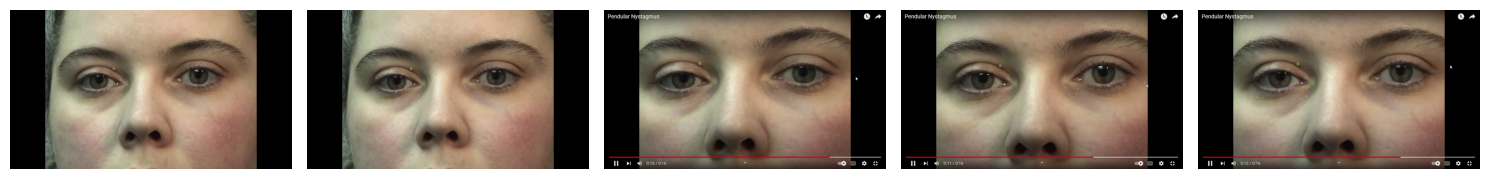

In [1]:
import cv2
import random
import matplotlib.pyplot as plt
from google.colab import files
import requests

# Upload the video from the local directory
uploaded_files = files.upload()

# Ensure a video file was uploaded
if not uploaded_files:
    raise ValueError("No file uploaded. Please upload a video file.")

# Assuming the first uploaded file is the video
video_filename = next(iter(uploaded_files))

# Open the video file
cap = cv2.VideoCapture(video_filename)

# Extract all frames from the video
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Release the video capture object
cap.release()

# Check if there are any frames extracted
if not frames:
    raise ValueError("No frames extracted from the video. Check the video file.")

# Decide on the number of frames to display (between 5 and 10)
num_display_frames = random.randint(5, 10)

# Randomly sample frames for display
display_frames = random.sample(frames, min(num_display_frames, len(frames)))

# Display the randomly sampled frames
fig, axes = plt.subplots(1, len(display_frames), figsize=(15, 5))
for ax, frame in zip(axes.flatten(), display_frames):
    ax.imshow(frame)
    ax.axis("off")
plt.tight_layout()
plt.show()



# Detecting the eyes region in the extracted frame

In [2]:
import requests

# URL of the file to be downloaded
url = 'https://github.com/anaustinbeing/haar-cascade-files/raw/b4c5af2e1393a29006ed3ae656caf9d021a0026a/haarcascade_eye.xml'

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Write the content of the response to a file
    with open('haarcascade_eye.xml', 'wb') as file:
        file.write(response.content)


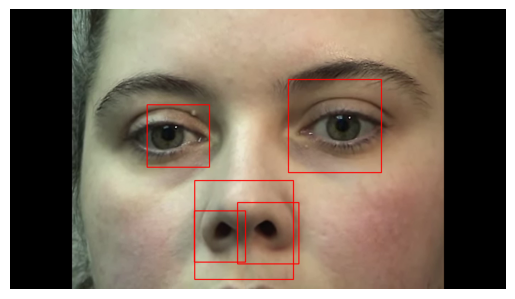

In [3]:
# Import necessary libraries
import cv2
import matplotlib.pyplot as plt

# Load the Haar cascades for eye detection
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# Here, we take the first frame
frame_0 = frames[0]

# Convert the frame to grayscale for detection
#gray_frame_0 = cv2.cvtColor(frame_0, cv2.COLOR_BGR2GRAY)

# Detect eyes in the first frame
eyes = eye_cascade.detectMultiScale(frame_0, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Draw rectangles around detected eyes
frame_0_with_detections = frame_0.copy()
for (x, y, w, h) in eyes:
    cv2.rectangle(frame_0_with_detections, (x, y), (x+w, y+h), (255, 0, 0), 2)

# Convert BGR image to RGB for displaying
#frame_0_with_detections = cv2.cvtColor(frame_0_with_detections, cv2.COLOR_BGR2RGB)

# Display the image with detections
plt.imshow(frame_0_with_detections)
plt.axis('off')
plt.show()


# Pupil detection

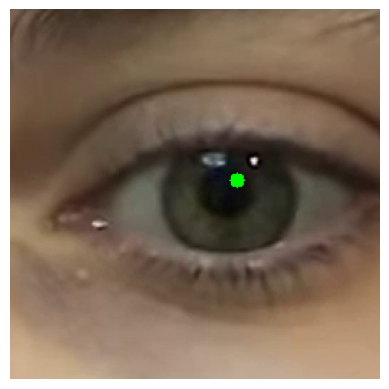

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def detect_pupil(eye_region):
    """
    Detect pupil in the given eye region.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(eye_region, cv2.COLOR_RGB2GRAY)

    # Use a binary threshold to segment the pupil
    _, thresholded = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY_INV)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If any contour is detected, choose the largest (assuming it corresponds to the pupil)
    if contours:
        max_contour = max(contours, key=cv2.contourArea)
        M = cv2.moments(max_contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        else:
            cx, cy = 0, 0
        return (cx, cy)
    else:
        return None

# Make sure to replace these with actual data or code to get them.
(x, y, w, h) = eyes[0]
eye_region = frame_0[y:y+h, x:x+w]

# Detect the pupil in the eye region
pupil_center = detect_pupil(eye_region)

# Draw the pupil center on the eye region
eye_region_with_pupil = eye_region.copy()
if pupil_center:
    cv2.circle(eye_region_with_pupil, pupil_center, 5, (0, 255, 0), -1)

# Convert BGR to RGB for matplotlib
#eye_region_with_pupil = cv2.cvtColor(eye_region_with_pupil, cv2.COLOR_BGR2RGB)

plt.imshow(eye_region_with_pupil)
plt.axis('off')
plt.show()


# Pupil movement tracking

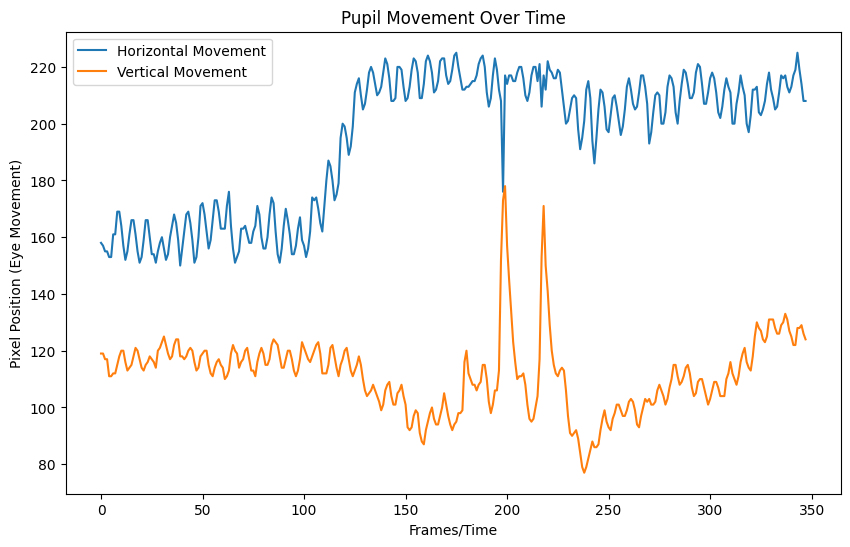

In [5]:
cap = cv2.VideoCapture(video_filename)

pupil_positions = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Extract the eye region using previously detected coordinates
    eye_region = frame_rgb[y:y+h, x:x+w]

    # Detect the pupil in the eye region
    pupil_center = detect_pupil(eye_region)

    if pupil_center:
        pupil_positions.append(pupil_center)
    else:
        # If not detected, use the last known position
        pupil_positions.append(pupil_positions[-1] if pupil_positions else (w//2, h//2))

cap.release()

# Plot the movement of the pupil
x_positions, y_positions = zip(*pupil_positions)
plt.figure(figsize=(10, 6))
plt.plot(x_positions, label="Horizontal Movement")
plt.plot(y_positions, label="Vertical Movement")
plt.title("Pupil Movement Over Time")
plt.xlabel("Frames/Time")
plt.ylabel("Pixel Position (Eye Movement)")
plt.legend()
plt.show()


In [6]:
import numpy as np
from scipy.signal import find_peaks, savgol_filter
from moviepy.editor import VideoFileClip
import IPython.display as ip_display
import os
import sys

def detect_nystagmus(x_positions, y_positions, video_path, threshold_frequency=0.13, window_length=5, polyorder=2):
    # 1. Smooth the data using Savitzky-Golay filter
    x_smooth = savgol_filter(x_positions, window_length, polyorder)
    y_smooth = savgol_filter(y_positions, window_length, polyorder)

    # 2. Find peaks with prominence in the smoothed data
    peaks_horizontal, properties_horizontal = find_peaks(x_smooth, prominence=1)  # prominence can be adjusted
    peaks_vertical, properties_vertical = find_peaks(y_smooth, prominence=1)  # prominence can be adjusted

    # 3. Calculate the average frequency of peaks for horizontal and vertical movement
    avg_frequency_horizontal = len(peaks_horizontal) / len(x_positions)
    avg_frequency_vertical = len(peaks_vertical) / len(y_positions)
    print(avg_frequency_horizontal)
    print(avg_frequency_vertical)

    # 4. Check for the presence of nystagmus based on frequency of peaks
    if avg_frequency_horizontal > threshold_frequency or avg_frequency_vertical > threshold_frequency:
        nystagmus_present = True
    else:
        nystagmus_present = False

    # 5. Play the video
    # Load the video clip
    eye_video = VideoFileClip(video_filename)

    # Display the video in the Jupyter notebook
    ip_display.display(eye_video.ipython_display(width=180))

    return nystagmus_present

# Call the function and check the result
nystagmus_detected = detect_nystagmus(x_positions, y_positions, video_filename)

# 6. Print the results whether the eye is healthy or there is nystagmus
if nystagmus_detected:
    print("Nystagmus is likely present in the eye movement data.")
else:
    print("No clear evidence of nystagmus in the eye movement data. It is a healthy eye movement.")


Output hidden; open in https://colab.research.google.com to view.

### :# **Nystagmus Check**

In [7]:
import numpy as np
from scipy.signal import find_peaks
from moviepy.editor import VideoFileClip
import IPython.display as ip_display
import os
import sys
from contextlib import contextmanager

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# 1. DETECTING NYSTAGMUS
# -----------------------
# The `find_peaks` function identifies peaks in the data, which can be indicative
# of rapid changes in pupil position (e.g., saccades or nystagmus beats).

# Find peaks in the horizontal and vertical data
peaks_horizontal, _ = find_peaks(x_positions)
peaks_vertical, _ = find_peaks(y_positions)

# Calculate the average frequency of peaks for horizontal and vertical movement
avg_frequency_horizontal = len(peaks_horizontal) / len(x_positions)
avg_frequency_vertical = len(peaks_vertical) / len(y_positions)
print(avg_frequency_horizontal)
print(avg_frequency_horizontal)
# Check for the presence of nystagmus based on frequency of peaks
# The threshold is set at 0.05 peaks per frame, but can be adjusted based on domain knowledge
threshold_frequency = 0.13
if avg_frequency_horizontal > threshold_frequency or avg_frequency_vertical > threshold_frequency:
    nystagmus_present = True
else:
    nystagmus_present = False

# Play the video
eye_video = VideoFileClip(video_filename)

with suppress_stdout():
    # Load the video clip
    eye_video = VideoFileClip(video_filename)

    # Display the video in the Jupyter notebook
    ip_display.display(eye_video.ipython_display(width=180))

# Print the results whether the eye is healthy or there is nystagmus
if nystagmus_present:
    print("Nystagmus is likely present in the eye movement data.")
else:
    print("No clear evidence of nystagmus in the eye movement data. It is a healthy eye movement.")


Output hidden; open in https://colab.research.google.com to view.

# Nystagmus Type

Either Pendular, Jerk or Upbeat Nystagmus


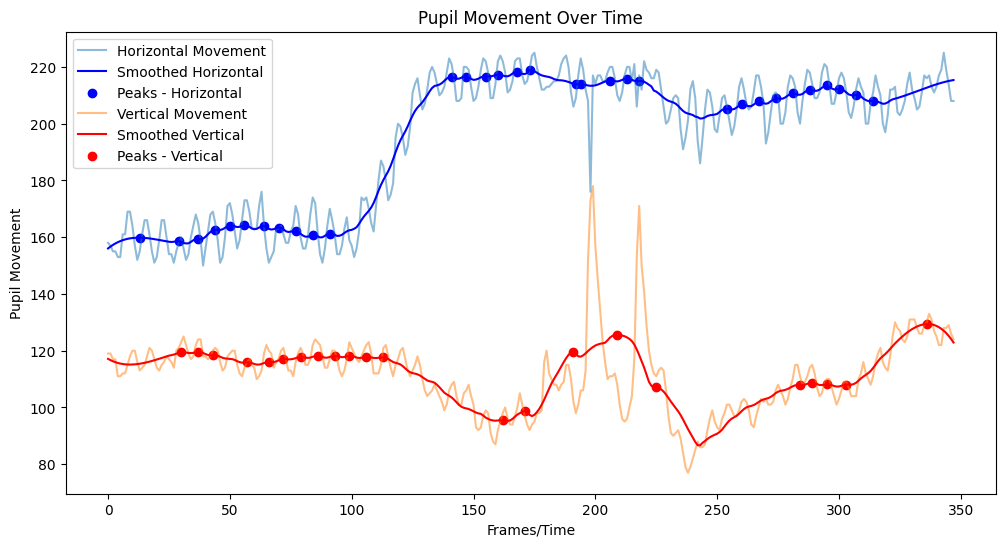


Based on the provided analysis, the detected nystagmus type is: Pendular Nystagmus
Average Amplitude - Horizontal: 194.67
Average Amplitude - Vertical: 111.61
Average Frequency - Horizontal: 0.09 peaks per frame
avg_frequency_vertical: 0.06 peaks per frame
avg_interval_horizontal: 9.71 peaks per frame
horizontal_amplitude_difference: -56.26 peaks per frame
vertical_amplitude_difference: -11.06 peaks per frame


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks

# 1. SMOOTHING USING THE SAVITZKY-GOLAY FILTER
smoothed_horizontal = savgol_filter(x_positions, window_length=51, polyorder=3)
smoothed_vertical = savgol_filter(y_positions, window_length=51, polyorder=3)

# 2. HIGHLIGHTING PEAKS
peaks_horizontal, _ = find_peaks(smoothed_horizontal)
peaks_vertical, _ = find_peaks(smoothed_vertical)

# 3. PLOTTING THE DATA
plt.figure(figsize=(12, 6))
plt.plot(x_positions, label='Horizontal Movement', alpha=0.5)
plt.plot(smoothed_horizontal, label='Smoothed Horizontal', color='blue')
plt.scatter(peaks_horizontal, smoothed_horizontal[peaks_horizontal], color='blue', marker='o', label='Peaks - Horizontal')
plt.plot(y_positions, label='Vertical Movement', alpha=0.5)
plt.plot(smoothed_vertical, label='Smoothed Vertical', color='red')
plt.scatter(peaks_vertical, smoothed_vertical[peaks_vertical], color='red', marker='o', label='Peaks - Vertical')
plt.legend()
plt.xlabel('Frames/Time')
plt.ylabel('Pupil Movement')
plt.title('Pupil Movement Over Time')
plt.show()

# 4. COMPUTING METRICS
avg_amplitude_horizontal = np.mean(smoothed_horizontal)
avg_amplitude_vertical = np.mean(smoothed_vertical)
avg_frequency_horizontal = round(len(peaks_horizontal) / len(x_positions),2)
avg_frequency_vertical = round(len(peaks_vertical) / len(y_positions),2)

# Refined thresholds for nystagmus detection
pendular_threshold_min = 0.04
pendular_threshold_max = 0.08
jerk_interval_threshold_horizontal_min = 0.05 * len(x_positions)
jerk_interval_threshold_horizontal_max = 0.09 * len(x_positions)
jerk_interval_threshold_vertical_min = 0.05 * len(y_positions)
jerk_interval_threshold_vertical_max = 0.09 * len(y_positions)
bruns_threshold_min = 0.02
bruns_threshold_max = 0.06
upbeat_threshold_min = 0.03
upbeat_threshold_max = 0.09

# Jerk Nystagmus detection
peak_intervals_horizontal = np.diff(peaks_horizontal)
peak_intervals_vertical = np.diff(peaks_vertical)
avg_interval_horizontal = np.mean(peak_intervals_horizontal)
avg_interval_vertical = np.mean(peak_intervals_vertical)

# Detecting different types of nystagmus using refined thresholds
nystagmus_type = " "

# Bruns Nystagmus detection
horizontal_amplitude_difference = np.mean(smoothed_horizontal[:10]) - np.mean(smoothed_horizontal[-10:])
vertical_amplitude_difference = np.mean(smoothed_vertical[:10]) - np.mean(smoothed_vertical[-10:])

# Pendular Nystagmus detection
if pendular_threshold_min <= avg_frequency_horizontal <= pendular_threshold_max or pendular_threshold_min <= avg_frequency_vertical <= pendular_threshold_max:
    nystagmus_type = "Pendular Nystagmus"

#elif jerk_interval_threshold_horizontal_min <= avg_interval_horizontal <= jerk_interval_threshold_horizontal_max:
 #   nystagmus_type += " | Jerk Nystagmus - Horizontal"

#elif jerk_interval_threshold_vertical_min <= avg_interval_vertical <= jerk_interval_threshold_vertical_max:
    #nystagmus_type += " | Jerk Nystagmus - Vertical"

elif vertical_amplitude_difference >= avg_amplitude_vertical and upbeat_threshold_min <= avg_frequency_vertical <= upbeat_threshold_max:
   nystagmus_type += "Upbeat Nystagmus"

#elif avg_interval_horizontal >= horizontal_amplitude_difference and bruns_threshold_min <= avg_frequency_horizontal <= bruns_threshold_max:
 #   nystagmus_type += " Bruns Nystagmus - Horizontal"

else : nystagmus_type = "Healthy, Unknown or No Clear Nystagmus Pattern"


# Print the results
print(f"\nBased on the provided analysis, the detected nystagmus type is: {nystagmus_type}")
print(f"Average Amplitude - Horizontal: {avg_amplitude_horizontal:.2f}")
print(f"Average Amplitude - Vertical: {avg_amplitude_vertical:.2f}")
print(f"Average Frequency - Horizontal: {avg_frequency_horizontal:.2f} peaks per frame")
print(f"avg_frequency_vertical: {avg_frequency_vertical:.2f} peaks per frame")
print(f"avg_interval_horizontal: {avg_interval_horizontal:.2f} peaks per frame")
print(f"horizontal_amplitude_difference: {horizontal_amplitude_difference:.2f} peaks per frame")
print(f"vertical_amplitude_difference: {vertical_amplitude_difference:.2f} peaks per frame")




# Pupil Movement Trajectory

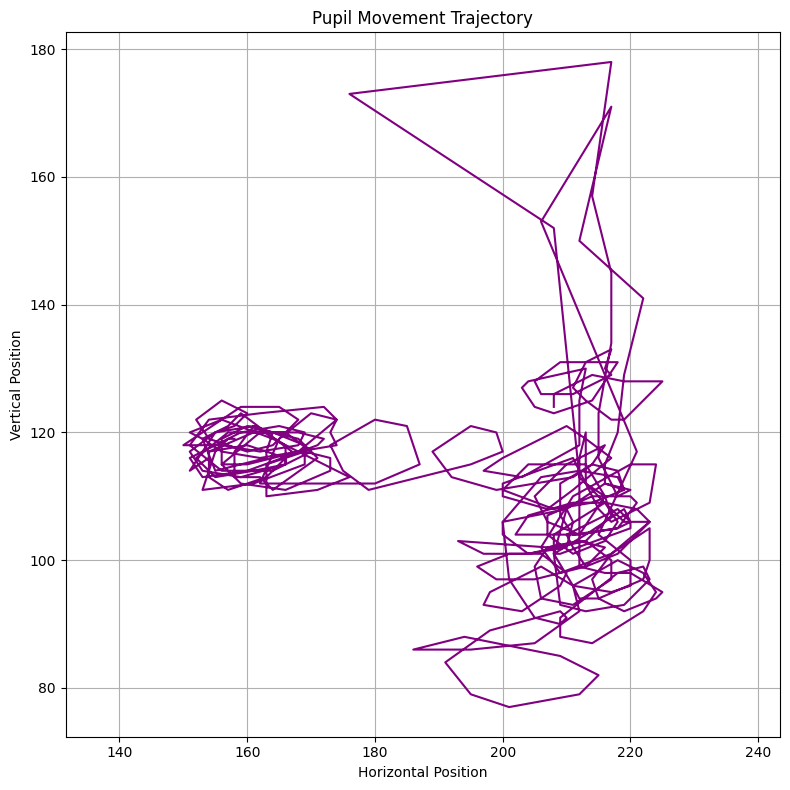

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming x_positions and y_positions are your pupil movement data arrays

# Plotting the trajectory of the pupil movements
plt.figure(figsize=(8, 8))

# Plotting x_positions against y_positions to show the trajectory
plt.plot(x_positions, y_positions, label="Pupil Trajectory", color='purple')
plt.title("Pupil Movement Trajectory")
plt.xlabel("Horizontal Position")
plt.ylabel("Vertical Position")
plt.grid(True)
plt.axis('equal')  # This ensures the scale is the same on both axes for accurate representation

plt.tight_layout()
plt.show()


# New section

# Pupil Movement Waveform Over Time

In [10]:
import numpy as np
import plotly.express as px

def plot_combined_waveform(x_positions, y_positions):
    # Data validation
    if len(x_positions) != len(y_positions) or not isinstance(x_positions, np.ndarray) or not isinstance(y_positions, np.ndarray):
        raise ValueError("x_positions and y_positions must be valid NumPy arrays with the same length.")

    # Calculate the average of horizontal and vertical movements
    combined_waveform = (x_positions + y_positions) / 2

    # Create a time array based on the length of your data
    time = np.arange(len(combined_waveform))

    # Create a DataFrame with time and combined_waveform data
    import pandas as pd
    df = pd.DataFrame({'Time': time, 'Combined_Waveform': combined_waveform})

    # Create an interactive plot using Plotly Express
    fig = px.line(df, x='Time', y='Combined_Waveform', title='Combined (x and y) Pupil Movement Waveform Over Time',
                  labels={'Combined_Waveform': 'Position'})
    fig.update_traces(line=dict(color='purple'), marker=dict(size=3))

    # Center the title
    fig.update_layout(title_x=0.5)  # Set title_x to 0.5 for center alignment

    # Show the plot
    fig.show()

# Example usage
x_positions = np.array(x_positions)
y_positions = np.array(y_positions)
plot_combined_waveform(x_positions, y_positions)


# New section

# Vertical & Horizontal Eye Movements Over Time

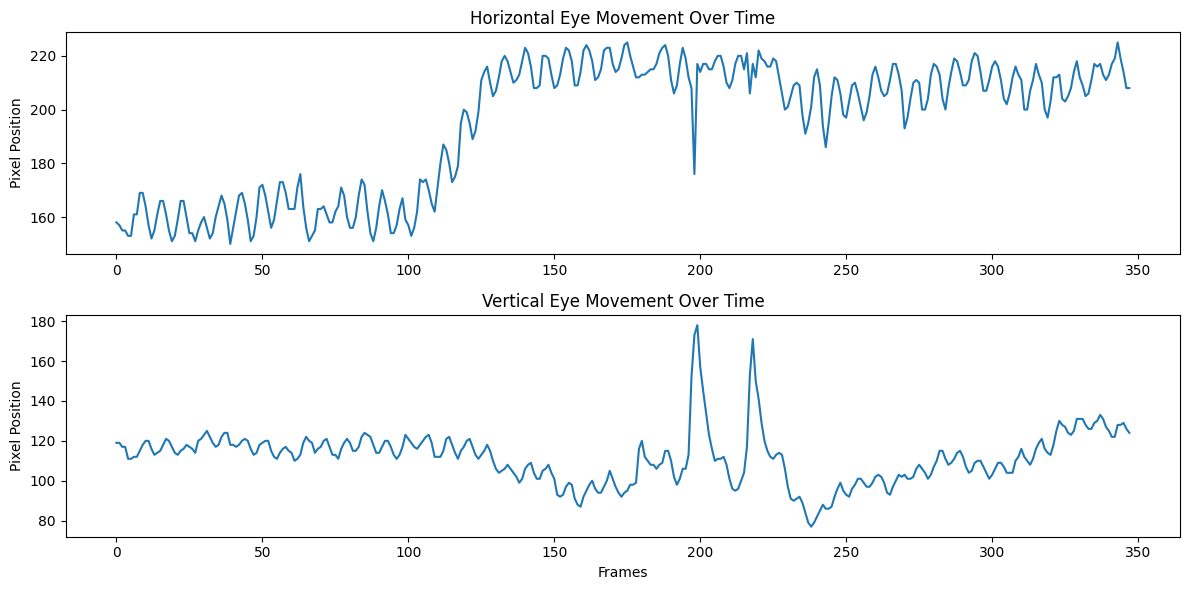

In [11]:
# Plotting the horizontal and vertical movements

plt.figure(figsize=(12, 6))

# Horizontal movement plot
plt.subplot(2, 1, 1)
plt.plot(x_positions, label="Horizontal Movement")
plt.title("Horizontal Eye Movement Over Time")
plt.ylabel("Pixel Position")

# Vertical movement plot
plt.subplot(2, 1, 2)
plt.plot(y_positions, label="Vertical Movement")
plt.title("Vertical Eye Movement Over Time")
plt.xlabel("Frames")
plt.ylabel("Pixel Position")

plt.tight_layout()
plt.show()
